In [2]:
#!/usr/bin/python
import sys
import pickle
import pandas as pd
import numpy as np
import collections, operator
from pprint import pprint
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import explore_data

import warnings
warnings.filterwarnings('ignore')


In [3]:
# full list

"""Task 1: Select features features_list is a list of strings, 
each of which is a feature name. The first feature is "poi"."""

features_list = [
    'poi',
    'salary',
    'to_messages',
    'deferral_payments',
    'total_payments',
    'exercised_stock_options',
    'bonus',
    'restricted_stock',
    'shared_receipt_with_poi',
    'restricted_stock_deferred',
    'total_stock_value',
    'expenses',
    'loan_advances',
    'from_messages',
    'other',
    'from_this_person_to_poi',
    'director_fees',
    'deferred_income',
    'long_term_incentive',
    'from_poi_to_this_person',
    ]

### Load the dictionary containing the dataset

with open('final_project_dataset.pkl', 'r') as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)

### Explore data
print('####### Explore Data #########')

from explore_data import find_highest_paid, count_valid_values
count_valid_values(data_dict)
print ''
print 'Count of people: ', len(data_dict)
poiCount = sum(p['poi'] == 1 for p in data_dict.values())
print 'Count of POIs: ', poiCount
# visualize_data(data_dict, features_list)

# print 'Missing data in each column'
# print df.isnull().sum()

####### Explore Data #########
Valid values: 
{'bonus': 82,
 'deferral_payments': 39,
 'deferred_income': 49,
 'director_fees': 17,
 'email_address': 111,
 'exercised_stock_options': 102,
 'expenses': 95,
 'from_messages': 86,
 'from_poi_to_this_person': 86,
 'from_this_person_to_poi': 86,
 'loan_advances': 4,
 'long_term_incentive': 66,
 'other': 93,
 'poi': 146,
 'restricted_stock': 110,
 'restricted_stock_deferred': 18,
 'salary': 95,
 'shared_receipt_with_poi': 86,
 'to_messages': 86,
 'total_payments': 125,
 'total_stock_value': 126}

Count of people:  146
Count of POIs:  18


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
KAMINSKI WINCENTY J,275101.0,4607.0,NaN,1086821.0,850010.0,400000.0,126027.0,583.0,NaN,976037.0,...,NaN,14368.0,4669.0,171.0,False,NaN,NaN,323466.0,vince.kaminski@enron.com,41.0


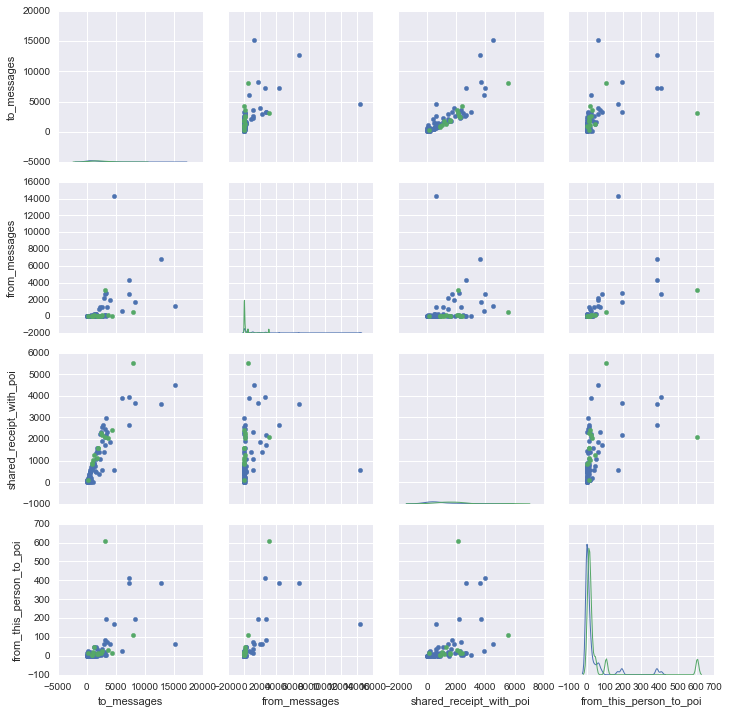

In [4]:
"""Task 2: Remove outliers
"""
df[df.salary > 2.0e7]
df[df.total_payments > 0.8e7]

g = sea.PairGrid(df, vars=['to_messages','from_messages','shared_receipt_with_poi','from_this_person_to_poi' ],
                hue='poi')
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.map_diag(sea.kdeplot, lw=1)
df[df.from_messages > 12000]

In [5]:
### Remove Outliers data_dict dropping: (is this necessary if convert back to_dict at end?)
outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'KAMINSKI WINCENTY J']
for outlier in outliers:
    data_dict.pop(outlier, 0)

In [6]:
### Correct data for Bhatnagar Sanjay

b_sandjay = data_dict['BHATNAGAR SANJAY']
b_sandjay['expenses'] = 137864
b_sandjay['total_payments'] = 137864
b_sandjay['exercised_stock_options'] = 15456734
b_sandjay['restricted_stock'] = 2604490
b_sandjay['restricted_stock_deferred'] = 2604490
b_sandjay['total_stock_value'] = 15456290
b_sandjay['director_fees'] = 'NaN'
b_sandjay['other'] = 'NaN'

### Correct data for B Robert
b_robert = data_dict["BELFER ROBERT"]
b_robert['deferred_income'] = 102500
b_robert['deferral_payments']= 'NaN'
b_robert['expenses'] = 3285
b_robert['directors_fees'] = 102500
b_robert['total_payments']=3285
b_robert['exercised_stock_options']='NaN'
b_robert['restricted_stock_options']=44093

In [7]:
'''Task 3: Create new features'''
for name in data_dict:
    to_messages = data_dict[name]['to_messages']
    from_messages = data_dict[name]['from_messages']
    to_user_from_poi = data_dict[name]['from_poi_to_this_person']
    from_user_to_poi = data_dict[name]['from_this_person_to_poi']
    shared_receipt = data_dict[name]['shared_receipt_with_poi']

    if to_messages != 'NaN' and to_user_from_poi != 'NaN':
        ratio_from_poi = float(to_user_from_poi)/float(to_messages)
    else:
        ratio_from_poi = 'NaN'
    if from_messages != 'NaN' and from_user_to_poi != 'NaN':
        ratio_to_poi = float(from_user_to_poi)/float(from_messages)
    else:
        ratio_to_poi = 'NaN'
    if to_messages != 'NaN' and shared_receipt != 'NaN':
        ratio_shared_receipt = float(shared_receipt)/float(to_messages)
    else:
        ratio_shared_receipt = 'NaN'
 
    data_dict[name]['ratio_from_poi'] = ratio_from_poi
    data_dict[name]['ratio_to_poi'] = ratio_to_poi
    data_dict[name]['ratio_shared_receipt'] = ratio_to_poi

In [92]:
# Add new features to features_list
# features_list.extend(['ratio_to_poi', 'ratio_from_poi','ratio_shared_poi'])

In [8]:
### Feature scaling
minmax_features = {}

for key in data_dict:
    for feature in features_list:
        feature_value = data_dict[key][feature]
        if feature_value != 'NaN':
            if not minmax_features.has_key(feature):
                minmax_features[feature] = \
                    {"min":feature_value,"max":feature_value}
            elif feature_value > minmax_features[feature]["max"]:
                minmax_features[feature]["max"]=feature_value
            elif feature_value < minmax_features[feature]["min"]:
                minmax_features[feature]["min"]=feature_value

for key in data_dict:
    for feature in features_list:
        feature_value = data_dict[key][feature]
        if feature != "poi" and feature_value != 'NaN':
            feature_value = data_dict[key][feature]
            minmax = minmax_features[feature]
            mrange = minmax['max']-minmax['min']
            feature_value = feature_value - minmax['min']
            feature_value = float(feature_value) / float(mrange)
            data_dict[key][feature] = feature_value

In [9]:
### Store to my_dataset for easy export below.
my_dataset = data_dict
# Convert dictionary to numpy array, converts NaN to 0.0  
# data = featureFormat(my_dataset, features_list, sort_keys = True, remove_all_zeroes = False)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [10]:
# set number of features
def doKbest(features, labels, k):
    k_select = SelectKBest(f_classif, k=k).fit(features, labels)
    scores = k_select.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features:\n ".format(k)
    pprint (k_best_features)
    print '\n'

def doPCAdata(data, n_components=''):
    from sklearn.decomposition import PCA
    pca = PCA(n_components).fit(data)
    variances= list(sorted(pca.explained_variance_ratio_))
    pprint (variances)
    print ''
    return pca

def doPCAsplit(features, labels, n_components=''):
    from sklearn.decomposition import PCA
    pca = PCA(n_components).fit(features, labels)
    variances = list(reversed(sorted([round(x,5) for x in pca.explained_variance_ratio_])))
    print "{0} best PCA explained variances:\n ".format(n_components)
    pprint (variances)
    print ''
#     first_pc = pca.components_[0]
#     second_pc = pca.components_[1]
    return pca


In [96]:
doKbest(features, labels, 8)
# doPCAdata(data, 5)
doPCAsplit(features, labels, n_components=17)

8 best features:
 
{'bonus': 20.298716684316961,
 'exercised_stock_options': 22.146106015134151,
 'long_term_incentive': 9.7290412578547478,
 'restricted_stock': 8.6508187125037725,
 'salary': 18.356713874203656,
 'shared_receipt_with_poi': 8.5144392038970178,
 'total_payments': 9.2030381533328391,
 'total_stock_value': 22.298877274809836}


17 best PCA explained variances:
 
[0.33458,
 0.22521,
 0.1098,
 0.07736,
 0.06084,
 0.03863,
 0.03061,
 0.02366,
 0.02231,
 0.01744,
 0.0168,
 0.01502,
 0.01031,
 0.00841,
 0.0047,
 0.00242,
 0.00185]



PCA(copy=True, n_components=17, whiten=False)

In [11]:
"""Task 4: Trying a variety of classifiers, using Pipelines for multi-stage
operations. (http://scikit-learn.org/stable/modules/pipeline.html)
*ran this operation first to see how the data cleaning and feature 
creation/extractions process affected the scores.""" 

# Import classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Import validation helpers
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, make_scorer, \
    precision_score, recall_score, classification_report
from sklearn.cross_validation import train_test_split, StratifiedKFold, \
    cross_val_score, StratifiedShuffleSplit

# Unsupervised PCA Pipeline - dimensionality reduction, learn patterns of variation in data
from sklearn.pipeline import Pipeline, FeatureUnion #http://scikit-learn.org/stable/modules/pipeline.html
from sklearn.decomposition import PCA #or doPCA
from sklearn.feature_selection import SelectKBest, f_classif


def assess_classifier(clf, X, y):
    cv = StratifiedShuffleSplit(y, 35, random_state=42)
    print clf, ' results: '
    print 'accuracy', round(cross_val_score(clf, X, y, cv=cv).mean(), 4)
    print 'precision', round(cross_val_score(clf, X, y,
                             scoring=make_scorer(precision_score),
                             cv=cv).mean(), 4)
    print 'recall', round(cross_val_score(clf, X, y,
                          scoring=make_scorer(recall_score),
                          cv=cv).mean(), 4)
def assess_features(X, y):
    clf = RandomForestClassifier(random_state=42) #  gini, entropy, max_depth, minimum_samples_split
    assess_classifier(clf, X, y)
    print
    clf = AdaBoostClassifier(random_state=42)
    assess_classifier(clf, X, y)
    print
    clf = GaussianNB()
    assess_classifier(clf, X, y)
def assess_forest(X, y):
    clf = RandomForestClassifier(random_state=42)
    assess_classifier(clf, X, y)
def assess_boost(X, y):
    clf = AdaBoostClassifier(random_state=42)
    assess_classifier(clf, X, y)

In [12]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
# from sklearn.cross_validation import train_test_split
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)

pca = PCA()
kbest = SelectKBest(f_classif)

forest_clf = RandomForestClassifier(random_state=42)
boost_clf = AdaBoostClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42)
svc_clf = SVC(class_weight='balanced', random_state=42)
# boost_clf.get_params().keys()

combined_features = FeatureUnion([("pca", PCA()), ("kbest", SelectKBest(f_classif))])

In [17]:
pipe = Pipeline(steps=[("features", combined_features), 
        ("boost", AdaBoostClassifier(random_state=42))])
param_grid_neigh = dict(features__pca__n_components= range(1,21,4),
                        features__kbest__k= range(1,21,4),
#                         features__pca__n_components= range(1,len(features_list)),
#                         features__kbest__k= range(1,len(features_list)),
                        boost__n_estimators =[1,15, 50, 75],
                        boost__learning_rate=[0.5,1, 2])  
    
boost_clf = GridSearchCV(pipe, param_grid=param_grid_neigh, verbose=3, \
    scoring = 'f1')
boost_clf.fit(features, labels)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1 
[CV]  features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1, score=0.000000 -   0.0s
[CV] features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1 
[CV]  features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1, score=0.333333 -   0.0s
[CV] features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1 
[CV]  features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1, score=0.000000 -   0.0s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=1, score

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.4s


[CV]  features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9, score=0.000000 -   0.0s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9, score=0.000000 -   0.0s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9, score=0.000000 -   0.0s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9, score=0.000000 -   0.0s
[CV] features__pca__n_components=9, boost__learning_rate=0.5, boost__n_estimators=1, features__kbest__k=9 
[CV]  features__pca__n_components=9, boost__

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    4.5s


[CV]  features__pca__n_components=13, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13, score=0.000000 -   0.1s
[CV] features__pca__n_components=13, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13 
[CV]  features__pca__n_components=13, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13, score=0.444444 -   0.0s
[CV] features__pca__n_components=17, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13 
[CV]  features__pca__n_components=17, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13, score=0.200000 -   0.1s
[CV] features__pca__n_components=17, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13 
[CV]  features__pca__n_components=17, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13, score=0.000000 -   0.1s
[CV] features__pca__n_components=17, boost__learning_rate=0.5, boost__n_estimators=15, features__kbest__k=13 
[CV]  features__pca_

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:   33.7s


[CV]  features__pca__n_components=1, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17, score=0.250000 -   0.3s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17, score=0.000000 -   0.2s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17, score=0.222222 -   0.2s
[CV] features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17 
[CV]  features__pca__n_components=5, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17, score=0.222222 -   0.2s
[CV] features__pca__n_components=9, boost__learning_rate=0.5, boost__n_estimators=75, features__kbest__k=17 
[CV]  features__pca__n_compo

[Parallel(n_jobs=1)]: Done 511 tasks       | elapsed:   53.7s


[CV]  features__pca__n_components=1, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17, score=0.400000 -   0.2s
[CV] features__pca__n_components=5, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17 
[CV]  features__pca__n_components=5, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17, score=0.000000 -   0.2s
[CV] features__pca__n_components=5, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17 
[CV]  features__pca__n_components=5, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17, score=0.250000 -   0.2s
[CV] features__pca__n_components=5, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17 
[CV]  features__pca__n_components=5, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17, score=0.461538 -   0.2s
[CV] features__pca__n_components=9, boost__learning_rate=1, boost__n_estimators=50, features__kbest__k=17 
[CV]  features__pca__n_components=9, boost__

[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  1.4min


[CV]  features__pca__n_components=5, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13, score=0.250000 -   0.2s
[CV] features__pca__n_components=5, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13 
[CV]  features__pca__n_components=5, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13, score=0.000000 -   0.2s
[CV] features__pca__n_components=9, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13 
[CV]  features__pca__n_components=9, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13, score=0.285714 -   0.2s
[CV] features__pca__n_components=9, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13 
[CV]  features__pca__n_components=9, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13, score=0.200000 -   0.2s
[CV] features__pca__n_components=9, boost__learning_rate=2, boost__n_estimators=50, features__kbest__k=13 
[CV]  features__pca__n_components=9, boost__

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x11702b050>))],
       transformer_weights=None)), ('boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'features__pca__n_components': [1, 5, 9, 13, 17], 'boost__learning_rate': [0.5, 1, 2], 'boost__n_estimators': [1, 15, 50, 75], 'features__kbest__k': [1, 5, 9, 13, 17]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=3)

In [19]:
print "Best Score: ", boost_clf.best_score_
print "Best Params: ",boost_clf.best_params_
print ''
print "Evaluation: "
assess_classifier(boost_clf.best_estimator_, features, labels)

Best Score:  0.407490396927
Best Params:  {'features__pca__n_components': 17, 'boost__learning_rate': 0.5, 'boost__n_estimators': 50, 'features__kbest__k': 17}

Evaluation: 
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=17, whiten=False)), ('kbest', SelectKBest(k=17, score_func=<function f_classif at 0x11702b050>))],
       transformer_weights=None)), ('boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=42))])  results: 
accuracy 0.859
precision 0.4524
recall 0.3143


#### Adaboost Tuning Results
Best Score:  0.407490396927
Best Params:  {'features__pca__n_components': 17, 'boost__learning_rate': 0.5, 'boost__n_estimators': 50, 'features__kbest__k': 17}

Evaluation: 
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=17, whiten=False)), ('kbest', SelectKBest(k=17, score_func=<function f_classif at 0x11702b050>))],
       transformer_weights=None)), ('boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=42))])  results: 
accuracy 0.859
precision 0.4524
recall 0.3143

In [13]:
pipe = Pipeline(steps=[("features", combined_features), 
        ("svc", SVC(class_weight='auto', random_state=42))])
param_grid_neigh = dict(features__pca__n_components= range(1,21,2),
                        features__kbest__k= range(1,21,2),
                        svc__kernel =['rbf'],
                        svc__C=[10000, 350000, 50000, 75000, 100000])  

svc_clf = GridSearchCV(pipe, param_grid=param_grid_neigh, verbose=3, \
    scoring = 'f1')
svc_clf.fit(features, labels)

svc_clf.get_params().keys()

print ''
print "Best Score: ", svc_clf.best_score_
print "Best Params: ",svc_clf.best_params_
print "Evaluation: "
assess_classifier(svc_clf.best_estimator_, features, labels)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] features__pca__n_components=1, svc__kernel=rbf, svc__C=10000, features__kbest__k=1 
[CV]  features__pca__n_components=1, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.000000 -   0.1s
[CV] features__pca__n_components=1, svc__kernel=rbf, svc__C=10000, features__kbest__k=1 
[CV]  features__pca__n_components=1, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.000000 -   0.0s
[CV] features__pca__n_components=1, svc__kernel=rbf, svc__C=10000, features__kbest__k=1 
[CV]  features__pca__n_components=1, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.500000 -   0.0s
[CV] features__pca__n_components=1, svc__kernel=rbf, svc__C=350000, features__kbest__k=1 
[CV]  features__pca__n_components=1, svc__kernel=rbf, svc__C=350000, features__kbest__k=1, score=0.000000 -   0.2s
[CV] features__pca__n_components=1, svc__kernel=rbf, svc__C=350000, features__kbest__k=1 
[CV]  features__pca__n_component

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    1.9s


[CV]  features__pca__n_components=5, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.222222 -   0.0s
[CV] features__pca__n_components=5, svc__kernel=rbf, svc__C=350000, features__kbest__k=1 
[CV]  features__pca__n_components=5, svc__kernel=rbf, svc__C=350000, features__kbest__k=1, score=0.250000 -   0.0s
[CV] features__pca__n_components=5, svc__kernel=rbf, svc__C=350000, features__kbest__k=1 
[CV]  features__pca__n_components=5, svc__kernel=rbf, svc__C=350000, features__kbest__k=1, score=0.000000 -   0.0s
[CV] features__pca__n_components=5, svc__kernel=rbf, svc__C=350000, features__kbest__k=1 
[CV]  features__pca__n_components=5, svc__kernel=rbf, svc__C=350000, features__kbest__k=1, score=0.266667 -   0.1s
[CV] features__pca__n_components=5, svc__kernel=rbf, svc__C=50000, features__kbest__k=1 
[CV]  features__pca__n_components=5, svc__kernel=rbf, svc__C=50000, features__kbest__k=1, score=0.266667 -   0.0s
[CV] features__pca__n_components=5, svc__kernel=rbf, svc__C=50000, f

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    5.3s


[CV]  features__pca__n_components=17, svc__kernel=rbf, svc__C=100000, features__kbest__k=1, score=0.444444 -   0.0s
[CV] features__pca__n_components=17, svc__kernel=rbf, svc__C=100000, features__kbest__k=1 
[CV]  features__pca__n_components=17, svc__kernel=rbf, svc__C=100000, features__kbest__k=1, score=0.461538 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=10000, features__kbest__k=1 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.375000 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=10000, features__kbest__k=1 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.250000 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=10000, features__kbest__k=1 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=10000, features__kbest__k=1, score=0.500000 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=3

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    9.6s


[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=50000, features__kbest__k=3 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=50000, features__kbest__k=3, score=0.444444 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=50000, features__kbest__k=3 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=50000, features__kbest__k=3, score=0.500000 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=75000, features__kbest__k=3 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=75000, features__kbest__k=3, score=0.470588 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=75000, features__kbest__k=3 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=75000, features__kbest__k=3, score=0.444444 -   0.0s
[CV] features__pca__n_components=19, svc__kernel=rbf, svc__C=75000, features__kbest__k=3 
[CV]  features__pca__n_components=19, svc__kernel=rbf, svc__C=75000, features__kbest__k=3,

[Parallel(n_jobs=1)]: Done 511 tasks       | elapsed:   16.3s


[CV] features__pca__n_components=9, svc__kernel=rbf, svc__C=50000, features__kbest__k=7 
[CV]  features__pca__n_components=9, svc__kernel=rbf, svc__C=50000, features__kbest__k=7, score=0.444444 -   0.0s
[CV] features__pca__n_components=9, svc__kernel=rbf, svc__C=50000, features__kbest__k=7 
[CV]  features__pca__n_components=9, svc__kernel=rbf, svc__C=50000, features__kbest__k=7, score=0.250000 -   0.0s
[CV] features__pca__n_components=9, svc__kernel=rbf, svc__C=50000, features__kbest__k=7 
[CV]  features__pca__n_components=9, svc__kernel=rbf, svc__C=50000, features__kbest__k=7, score=0.615385 -   0.0s
[CV] features__pca__n_components=9, svc__kernel=rbf, svc__C=75000, features__kbest__k=7 
[CV]  features__pca__n_components=9, svc__kernel=rbf, svc__C=75000, features__kbest__k=7, score=0.444444 -   0.0s
[CV] features__pca__n_components=9, svc__kernel=rbf, svc__C=75000, features__kbest__k=7 
[CV]  features__pca__n_components=9, svc__kernel=rbf, svc__C=75000, features__kbest__k=7, score=0.2

[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   24.0s


[CV] features__pca__n_components=7, svc__kernel=rbf, svc__C=50000, features__kbest__k=11 
[CV]  features__pca__n_components=7, svc__kernel=rbf, svc__C=50000, features__kbest__k=11, score=0.444444 -   0.0s
[CV] features__pca__n_components=7, svc__kernel=rbf, svc__C=50000, features__kbest__k=11 
[CV]  features__pca__n_components=7, svc__kernel=rbf, svc__C=50000, features__kbest__k=11, score=0.250000 -   0.0s
[CV] features__pca__n_components=7, svc__kernel=rbf, svc__C=50000, features__kbest__k=11 
[CV]  features__pca__n_components=7, svc__kernel=rbf, svc__C=50000, features__kbest__k=11, score=0.363636 -   0.0s
[CV] features__pca__n_components=7, svc__kernel=rbf, svc__C=75000, features__kbest__k=11 
[CV]  features__pca__n_components=7, svc__kernel=rbf, svc__C=75000, features__kbest__k=11, score=0.444444 -   0.0s
[CV] features__pca__n_components=7, svc__kernel=rbf, svc__C=75000, features__kbest__k=11 
[CV]  features__pca__n_components=7, svc__kernel=rbf, svc__C=75000, features__kbest__k=11,

[Parallel(n_jobs=1)]: Done 1151 tasks       | elapsed:   33.9s


[CV] features__pca__n_components=15, svc__kernel=rbf, svc__C=10000, features__kbest__k=15 
[CV]  features__pca__n_components=15, svc__kernel=rbf, svc__C=10000, features__kbest__k=15, score=0.444444 -   0.0s
[CV] features__pca__n_components=15, svc__kernel=rbf, svc__C=10000, features__kbest__k=15 
[CV]  features__pca__n_components=15, svc__kernel=rbf, svc__C=10000, features__kbest__k=15, score=0.500000 -   0.0s
[CV] features__pca__n_components=15, svc__kernel=rbf, svc__C=350000, features__kbest__k=15 
[CV]  features__pca__n_components=15, svc__kernel=rbf, svc__C=350000, features__kbest__k=15, score=0.470588 -   0.0s
[CV] features__pca__n_components=15, svc__kernel=rbf, svc__C=350000, features__kbest__k=15 
[CV]  features__pca__n_components=15, svc__kernel=rbf, svc__C=350000, features__kbest__k=15, score=0.444444 -   0.0s
[CV] features__pca__n_components=15, svc__kernel=rbf, svc__C=350000, features__kbest__k=15 
[CV]  features__pca__n_components=15, svc__kernel=rbf, svc__C=350000, featur

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   42.3s finished


 0.8667
precision 0.481
recall 0.5


In [101]:
print ''
print "Best Score: ", svc_clf.best_score_
print "Best Params: ",svc_clf.best_params_
print "Evaluation: "
assess_classifier(svc_clf.best_estimator_, features, labels)
# features_selected_bool = svc_clf.best_estimator_.named_steps['features'].get_support()
# print features_selected_bool


Best Score:  0.519802576141
Best Params:  {'features__pca__n_components': 15, 'svc__kernel': 'rbf', 'svc__C': 10000, 'features__kbest__k': 3}
Evaluation: 
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=15, whiten=False)), ('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x1170396e0>))],
       transformer_weights=None)), ('svc', SVC(C=10000, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])  results: 
accuracy 0.8552
precision 0.45
recall 0.5286


#### SVC Tuning Results
Best Score:  0.519802576141
Best Params:  {'features__pca__n_components': 15, 'svc__kernel': 'rbf', 'svc__C': 10000, 'features__kbest__k': 3}
Evaluation: 
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=15, whiten=False)), ('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x1170396e0>))],
       transformer_weights=None)), ('svc', SVC(C=10000, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])  results: 
accuracy 0.8552
precision 0.45
recall 0.5286

In [1]:
# doKbest(features, labels, 3)
# doPCAsplit(features, labels, 15)

kbest = svc_clf.best_params_.get('features__kbest__k')
doKbest(features, labels, kbest)
n_components = svc_clf.best_params_.get('features__pca__n_components')
doPCAsplit(features, labels, n_components)

NameError: name 'svc_clf' is not defined

In [44]:
from tester import test_classifier

# test_classifier(boost_clf,my_dataset, features_list, folds = 200)
# test_classifier(forest_clf,my_dataset, features_list, folds = 200)
# test_classifier(svc_clf,my_dataset, features_list, folds = 200)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=15, whiten=False)), ('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x11702b050>))],
       transformer_weights=None)), ('svc', SVC(C=10000, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.84633	Precision: 0.43384	Recall: 0.50000	F1: 0.46458	F2: 0.48520
	Total predictions: 3000	True positives:  200	False positives:  261	False negatives:  200	True negatives: 2339



In [102]:
### Task 6: Dump classifier, dataset, and features_list to pkl files
# choose classifier and automatically set params to submit, forest_clf, boost_clf, gnb_clf
clf = svc_clf.best_estimator_ 

# submit final features_list
my_feature_list = features_list

dump_classifier_and_data(clf, my_dataset, my_feature_list)

### Short Answers

---
*1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]*

This project aims to train a machine learning classifier over the varied corpus of discrete, and at times seemingly disparate Enron data, to accurately predict persons-of-interests in detecting fraud. While the Enron case happened in the past, this classifier could be potentially applied to companies with similar datasets to detect fraudulent behavior of employees. Machine learning techniques are employed to vigorously train and rigourously test various algorithms to process a large amount of data - more data than one person can accurately process. Techniques to perform dimensionality reduction of the data, ie see patterns of data variance to draw out new predictive features is also used through Principle Component Analysis.

The aggregated Enron email and financial dataset is stored in a dictionary, where each key in the dictionary is a person’s name and the value is a dictionary containing all the features of that person. The email and finance (E+F) data dictionary is stored as a pickle file, which is a handy way to store and load python objects directly. The features in the data fall into three major types, namely financial features, email features and POI labels.

Valid values: 
{'bonus': 82,
 'deferral_payments': 39,
 'deferred_income': 49,
 'director_fees': 17,
 'email_address': 111,
 'exercised_stock_options': 102,
 'expenses': 95,
 'from_messages': 86,
 'from_poi_to_this_person': 86,
 'from_this_person_to_poi': 86,
 'loan_advances': 4,
 'long_term_incentive': 66,
 'other': 93,
 'poi': 146,
 'restricted_stock': 110,
 'restricted_stock_deferred': 18,
 'salary': 95,
 'shared_receipt_with_poi': 86,
 'to_messages': 86,
 'total_payments': 125,
 'total_stock_value': 126}

Count of people:  146
Count of POIs:  18

Outliers removed: 
('KAMINSKI WINCENTY J') - an employee that was a mass emailer, removed to ensure the validity of email features weren't skewed.
('THE TRAVEL AGENCY IN THE PARK') - not an employee! (I don't think)
('TOTAL') - skewed all the data
(['email_address']) - not an outlier, but an obvious addition of noise to the model, as it acts as a redundant identification variable for each case. 

The strongest outlier in the dataset was the row containing the total of all the columns. The algorithm predictions improved significantly after this row was removed. There was also an employee who sent more emails than double the next highest number. This entity was removed to prevent it from skewing the average amount of emails sent out as a possible marker.

In terms of setting up the data to provide the most predictive power, I dropped the email address column, as this is a redundant identification variable.

One of the biggest issues, and hindrances for me finishing this project successfully, was imputing the median and mean values of the variables for NaN data. There was so much missing data, that this probably skewed the efficacy of the data's predictive power. Once I replaced the NaN values with '0', I started to hit considerably better results aross the board for all classifiers. I really learned how important the ratio of missing values is, in determining how to proceed with imputing vs. substituting data.

---

*2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? Engineer and explain your own feature that did not come ready made in the dataset -- what was the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the scores_and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]*

I decided to code up a new feature that considers the ratio of messages *sent to* and ratio of messages that *came from* a POI. As corruption is rarely a one person endeavor, this feature would indicate a network exhibit through email exchange. From the EDA scatterplot, we can see that if a person has a ratio of messages TO a POI of less than ~0.18 and a ratio FROM a POI of less than ~0.25, then  they probably are not a POI. This new feature added to the predictive value of our model.

From my time working at a investment advisory firm, looking at public company incentive structures, I used my domain knowledge and understanding of human psychology to explore engineering new long vs. short term incentive structure features. 

After much parsing through the different iterations of engineering long and short term incentive features, there did not seem to be a simple configuration that could be added to the model. The ratios of (long term payoff(restricted stock and long term incentives):expenses plus bonuses) plotted against ratios of (long term payoffs:exercised stock options) could possibly be used as decision tree predictors, so those features were kept. After testing the models with these LT/ST features, however, they actually brought down the accuracy, precision, and recall across all three classifiers. So I will excluded these from my final project. I am open to the possibility that this behavior may change with larger datasets.

I recorded the scores here:  
[Score Tracker](
https://docs.google.com/spreadsheets/d/17Dfc6YY4BEzsf_n7j4Rp8hUX8GlvsQmZPr80iMbHKEA/edit?usp=sharing)

|1- Initial	|2 - drop outliers	|3 - new email ratio features	|3 - new LT/ST feature|
|--------------------|
|Random Forest|
|0.8472	|0.8541	|0.8629	|0.861|
|0.1452	|0.1991	|0.2239	|0.1916|
|0.1015	|0.126	|0.143	|0.115|
|Adaboost|			
|0.8449	|0.8415	|0.8511	|0.8207|
|0.3407	|0.3189	|0.3687	|0.259|
|0.3045	|0.2905	|0.335	|0.265|
|Gaussian NB|			
|0.3819	|0.7391	|0.739	|0.5746|
|0.1702	|0.2698	|0.2696	|0.2035|
|0.831	|0.3805	|0.38	|0.6|

Before I learned how to use SelectKBest in Pipeline and GridsearchCV, I spent a lot of time dropping unimportant features upon each parameter tune of my algorithms (evidenced by my run-off code). This very effectively taught me the value of using Pipeline to automate and clean up this process. I got dramatically different results using marginally different amounts of features. I'm not sure how much this is a function of the limited dataset or the process of feature selecting in general. Looking forward to working on larger datasets.

In sum, I used univariate (not recursive) feature selection with the SelectKBest algorithm.

3 best features used in the submitted SVC classifier:

| Feature                 | Importance |
| :-----------------------| ---------  |
|'total_stock_value'      | 22.299|
|'exercised_stock_options'| 22.146|
|'bonus'                  | 20.299|
|'salary'| 18.357|
|'long_term_incentive'| 9.729|

17 best PCA explained variances:
 
[0.33458,
 0.22521,
 0.1098,
 0.07736,
 0.06084,
 0.03863,
 0.03061,
 0.02366,
 0.02231,
 0.01744,
 0.0168,
 0.01502,
 0.01031,
 0.00841,
 0.0047,
 0.00242,
 0.00185]

I tried using the [minmaxscaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but this did not change the scores of the Forest and Adaboost classifiers. However, I added feature scaling with a custom function outside of the pipeline when I implemented the SVC algorithm, as it requires feature scaling. This ensures that the variables are sclaed by the min/max of the whole set, not just the training/testing set.

When using PCA or SVM, it can also be helpful to center the data using something like [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

---
*3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]*


*Random Forest (bagging voting):* 
The Random Forest ensemble learner is a series of decision trees built on randomized subsets of the data. 
At each node, a randomized subset of variables is evaluated to find the best split. This creates a “forest” of independent, randomized trees. The predictions of all the trees are averaged to assign a predicted label. 

**Adaboost:**
AdaBoost is by default an ensemble of decision trees (although the base classifier can be altered), but the trees are not independent. First, a single tree is fit using all of the data. Incorrectly assigned points are then given a higher weight (boosted) and the process is repeated. By default, adaboost uses single feature trees of depth 1 (decision stumps)

**Adaboost Tuning Results:**
Best Score:  0.407490396927
Best Params:  {'features__pca__n_components': 17, 'boost__learning_rate': 0.5, 'boost__n_estimators': 50, 'features__kbest__k': 17}

Evaluation: 
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=17, whiten=False)), ('kbest', SelectKBest(k=17, score_func=<function f_classif at 0x11702b050>))],
       transformer_weights=None)), ('boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=42))])  results: 
accuracy 0.859
precision 0.4524
recall 0.3143

**Support Vector Classifier:**
Best Score:  0.538581918864
Best Params:  {'features__pca__n_components': 17, 'svc__kernel': 'rbf', 'svc__C': 35000, 'features__kbest__k': 5}

Evaluation: 
Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=17, whiten=False)), ('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x1164e38c0>))],
       transformer_weights=None)), ('svc', SVC(C=35000, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])  results: 
accuracy 0.8686
precision 0.4857
recall 0.5

The final classifier submitted was a SVC with the parameters outlined above. 

For this project, I wanted to learn a huge range of classifiers to build up a repertoire for future projects. I preliminarily tried KNN, Support Vector Machine, and Gaussian Naive Bayes, but decided to focus on tuning and testing Adaboost and Random Forest ensemble classifiers. These classifiers have proven to be very powerful at Kaggle competitions, and I love exploring everything related to information entropy. Even though they are not primarily known for classification tasks, and wouldn't work well in integrating new data, they work well for the purposes of this project. I would love to explore which algorithms are best for introducing new data to the classifier, or in other words are best for continuous integration.

---
*4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]*

Tuning parameters of an algorithm is much like tuning a music string between flat and sharpe; one tunes the algorithm between bias and variance to get a better score for a metric that one is optimizing for (ie. accuracy, precision or recall). It may be the no. of nodes or the minimum amount of samples needed for a decision tree split; it may be tuning the *learning rates* of weak learners' in AdaBoost; Or, it may be toggling the number of clusters in a Kmeans.

To systematically and automatically iterate through all the scores of varying parameter combinations, the GridSearchCV, paired with a pipeline to include the principal components in the model, is an extremely helpful tool.

---
*5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]*

Validation is performed to ensure that the classifier has strong external validity. A classic mistake it aims to avoid is overfitting the data, where the classifier is tuned to closely to only one case of the training/testing split of the data. 

To avoid this, I used the [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html), which is a merged cross-validation object of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds.   

---
*6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]*

**Accuracy:**
As the dataset in this project is very small and the ratio of negatives to positives is highly skewed (18 POIs out of 146 total cases), a classifier that predicted only non-POIs as output, would obtain an accuracy score of 87.4%. In this regard, accuracy is not a strong validation metric for our classifier. 

Instead, precision and recall were used to evaluate the information gain and reliability of the classifier to identify POIs.

**Precision(TP/TP+FP):**

The precision value scores the ratio of true positive estimations over all positive estimations (true or false). In this project, it's the probability that a POI identified by the estimator (a positive) actually is a POI (a true positive). The probability of randomly sampling a POI from the dataset is about 0.12 and the probability of the algorithm to predict a true positive (out of all the positives it suggests) is on average 0.39. This suggests we are gaining information when using the estimator, and it is a *sufficient* hueristic for this goals of this project, but I believe a more offensive metric is a *necessary* hueristic to address fraud detection.

**Recall (TP/TP+FN):**
The [adaboosted decision tree?] achieved a recall value of [0.308], suggesting that 69.2% of POIs go undetected. One could argue that this number is too low, as there is a lower cost to proving a non-corrupt person innocent compared to the cost of missing a true POI who would get away with fraudulently obtaining millions of dollars, however 

In this context, recall is more important than precision (and accuracy) so re-tuning the algorithm to yield a better recall value at the cost of precision would be a more effective system in production to help in fraud detection. 

Given a larger dataset, perhaps fraud corpuses across companies, accuracy may prove to be a more relevant metric, however the negative to positive ratios would (hopefully) stay highly skewed.